# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

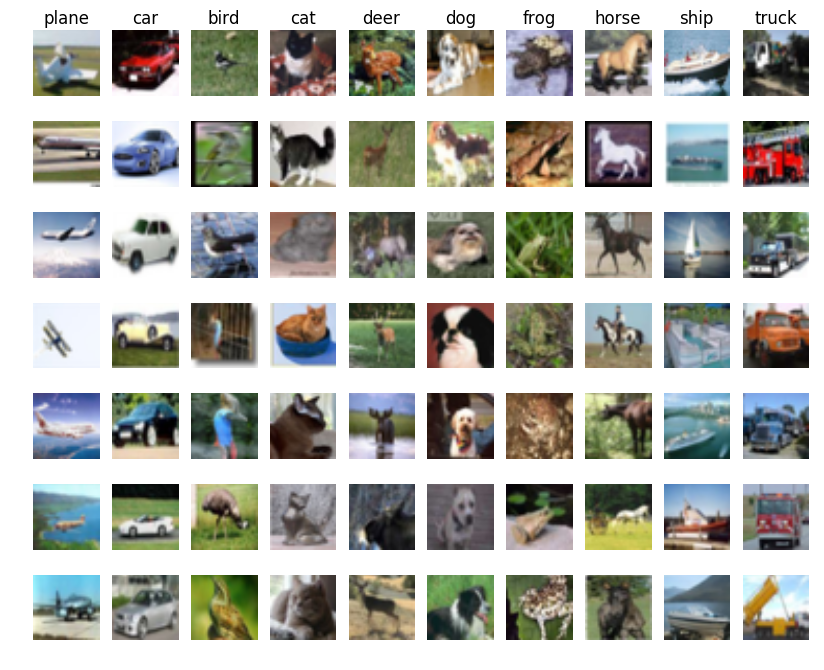

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Так задаётся архитектура нейронки

In [148]:
a = np.zeros((32, 32, 3))
print a.shape
b = a.reshape((3, 32, 32))
print b.shape

(32, 32, 3)
(3, 32, 32)


In [153]:
X_train1 = [x for x in X_train]
for i in range(len(X_train)):
    b = X_train[i]
    X_train1[i] = b.reshape((3, 32, 32))
X_train1 = np.array(X_train1)
print X_train1.shape

(50000, 3, 32, 32)


In [154]:
input_layer = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
conv1 = lasagne.layers.Conv2DLayer(input_layer, num_filters = 10, filter_size = (5, 5))
# Для вдохновления 
# - http://torch.ch/blog/2015/07/30/cifar.html
# - http://www.robots.ox.ac.uk/~vgg/research/very_deep/
# - https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
dense_output = lasagne.layers.DenseLayer(conv1, num_units = 10, nonlinearity=softmax)

In [155]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [156]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [157]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

In [159]:
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates_sgd, allow_input_downcast = True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast = True)

INFO (theano.gof.compilelock): Refreshing lock /home/kirillmouraviev/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.12-64/lock_dir/lock
Problem occurred during compilation with the command line below:
/usr/bin/g++ -shared -g -O3 -fno-math-errno -Wno-unused-label -Wno-unused-variable -Wno-write-strings -march=corei7 -mcx16 -msahf -mno-movbe -mno-aes -mno-pclmul -mpopcnt -mno-abm -mno-lwp -mno-fma -mno-fma4 -mno-xop -mno-bmi -mno-bmi2 -mno-tbm -mno-avx -mno-avx2 -mno-sse4.2 -mno-sse4.1 -mno-lzcnt -mno-rtm -mno-hle -mno-rdrnd -mno-f16c -mno-fsgsbase -mno-rdseed -mno-prfchw -mno-adx -mfxsr -mno-xsave -mno-xsaveopt --param l1-cache-size=32 --param l1-cache-line-size=64 --param l2-cache-size=3072 -mtune=corei7 -D NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -m64 -fPIC -I/home/kirillmouraviev/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/kirillmouraviev/anaconda2/include/python2.7 -I/home/kirillmouraviev/anaconda2/lib/python2.7/site-packages/the

OSError: [Errno 12] Cannot allocate memory

In [136]:
#print train_fun(X_train, y_train)
print updates_sgd
print X_train.shape

OrderedDict([(<TensorType(float64, matrix)>, Elemwise{add,no_inplace}.0), (W, Elemwise{sub,no_inplace}.0), (<TensorType(float64, vector)>, Elemwise{add,no_inplace}.0), (b, Elemwise{sub,no_inplace}.0)])
(50000, 32, 32, 3)


### Вот и всё, пошли её учить

In [137]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [138]:
print X_train.shape, input_layer.shape

(50000, 32, 32, 3) (None, 32, 32, 3)


In [139]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 10 took 5.385s
  training loss (in-iteration):		3360.925974
  train accuracy:		19.42 %
  validation accuracy:		17.12 %
Epoch 2 of 10 took 5.207s
  training loss (in-iteration):		3013.533122
  train accuracy:		22.16 %
  validation accuracy:		17.03 %


KeyboardInterrupt: 

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/FsANPB1jSqmX1JBJ3